Métricas de avaliação:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

Speedup

In [ ]:
def speedup(T1, Tp):
    """Calcula o speedup e classifica como sublinear, linear ou superlinear"""
    S = T1 / Tp
    if S < 1:
        tipo = "sublinear"
    elif S < Tp:
        tipo = "sublinear"
    elif S == Tp:
        tipo = "linear"
    else:
        tipo = "superlinear"
    return S, tipo

Eficiência

In [3]:
def eficiencia(S, p):
    """Calcula a eficiência"""
    return S / p

Redundância

In [4]:
def redundancia(tempo_cpu, tempo_clock):
    """Calcula a redundância"""
    return tempo_cpu / tempo_clock

Utilização

In [5]:
def utilizacao(E, R):
    """Calcula a utilização considerando eficiência e redundância"""
    if R == 0:
        return 0.0  
    return E / R

Cálculos

In [ ]:
cabecalho = ["modo","num_processos","tempo_clock","tempo_cpu","tempo_comunicacao","tempo_total","timestamp","notas"]

df = pd.read_csv("results/run_logs.csv", names=cabecalho)

linear = df[df['modo'] == 'linear'].iloc[0]
T1 = float(linear['tempo_clock'])

metricas = []

for _, row in df.iterrows():
    T_p = float(row['tempo_clock'])
    p = int(row['num_processos'])
    tempo_cpu = float(row['tempo_cpu'])
    
    # Para linear, S=1, Eficiência=1
    if row['modo'] == 'linear':
        S = 1.0
        tipo_speedup = "linear"
        E = 1.0
    else:
        # Para paralelo, calcular em relação ao tempo linear
        linear_row = df[df['modo'] == 'linear'].iloc[0]
        T1 = float(linear_row['tempo_clock'])
        S, tipo_speedup = speedup(T1, T_p)
        E = eficiencia(S, p)
    
    R = redundancia(tempo_cpu, T_p)
    U = utilizacao(E, R)
    
    S, tipo_speedup = speedup(T1, T_p)
    E = eficiencia(S, p)
    U = utilizacao(E, R)
    
    metricas.append({
        'num_processos': p,
        'Speedup': S,
        'Tipo Speedup': tipo_speedup,
        'Eficiência': E,
        'Redundância': R,
        'Utilização': U
    })

df_metricas = pd.DataFrame(metricas)
print(tabulate(df_metricas, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═════════════════╤═════════════╤════════════════╤══════════════╤═══════════════╤══════════════╕
│   num_processos │     Speedup │ Tipo Speedup   │   Eficiência │   Redundância │   Utilização │
╞═════════════════╪═════════════╪════════════════╪══════════════╪═══════════════╪══════════════╡
│               1 │ 1           │ superlinear    │  1           │     0         │  0           │
├─────────────────┼─────────────┼────────────────┼──────────────┼───────────────┼──────────────┤
│               8 │ 6.98487e-09 │ sublinear      │  8.73109e-10 │     0.927197  │  9.41665e-10 │
├─────────────────┼─────────────┼────────────────┼──────────────┼───────────────┼──────────────┤
│               8 │ 1.22399e-08 │ sublinear      │  1.52999e-09 │     0.0242435 │  6.3109e-08  │
├─────────────────┼─────────────┼────────────────┼──────────────┼───────────────┼──────────────┤
│               8 │ 1.81787e-08 │ sublinear      │  2.27233e-09 │     0.0156139 │  1.45532e-07 │
├─────────────────┼───────────

Gráficos

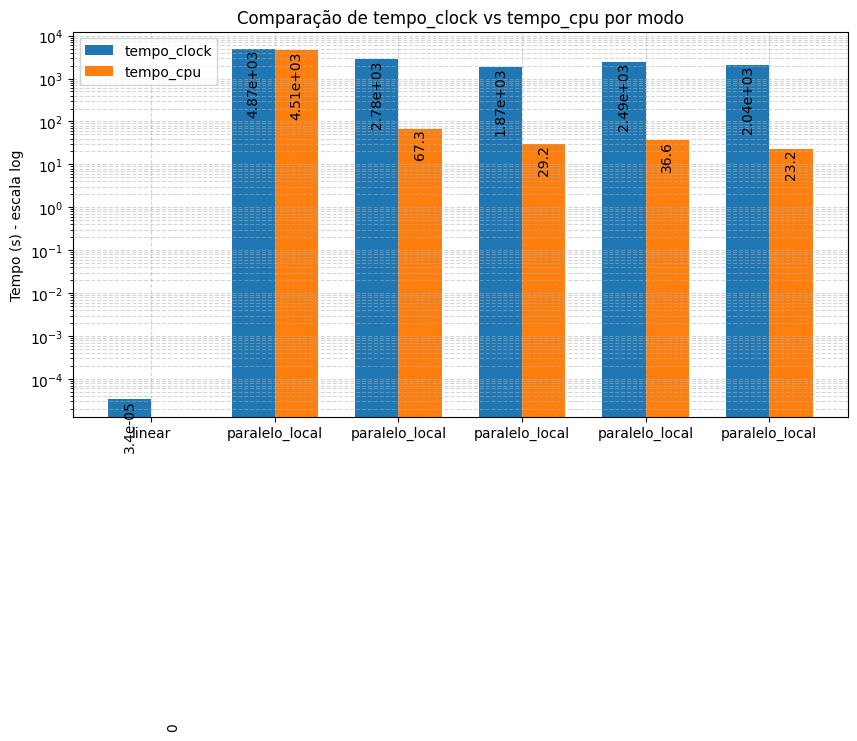

In [7]:
modes = df['modo'].astype(str).tolist()
tempo_clock = df['tempo_clock'].astype(float).tolist()
tempo_cpu = df['tempo_cpu'].astype(float).tolist()

x = list(range(len(modes)))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar([xi - width/2 for xi in x], tempo_clock, width=width, label='tempo_clock', color='C0')
plt.bar([xi + width/2 for xi in x], tempo_cpu, width=width, label='tempo_cpu', color='C1')

plt.xticks(x, modes)
plt.yscale('log')
plt.ylabel("Tempo (s) - escala log")
plt.title("Comparação de tempo_clock vs tempo_cpu por modo")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

for xi, tc, tp in zip(x, tempo_clock, tempo_cpu):
    plt.text(xi - width/2, tc if tc>0 else 1e-12, f"{tc:.3g}", ha='center', va='top', fontsize=10, rotation=90)
    plt.text(xi + width/2, tp if tp>0 else 1e-12, f"{tp:.3g}", ha='center', va='top', fontsize=10, rotation=90)

plt.show()